In [20]:
# Современные методы вычислительной математики и механики, 1 семестр, 2021 г.
# Лабораторная работа 2. Методы решения бигармонических уравнений: Метод КНК.
# Решение задачи через глобальную СЛАУ.
###########################
import numpy as np
import scipy as sp
import math
from matplotlib import  pyplot as plt
import copy

#Базис: Chebyshev или Monoms
Basis = 'Chebyshev'
N_degree = 5 # степень аппроксимирующего полинома
N_colloc = N_degree + 1 # количество точек коллокации
N_eq = N_colloc + 4 # Количество уравнений в локальной матрице

X0 = 0.0
X1 = 1.0
if(Basis == 'Monoms'):
    y_ = np.linspace(-1., 1., N_colloc+2, endpoint = True)
if(Basis == 'Chebyshev'):
    y_ = np.array([-np.cos(i / (N_colloc+1) * np.pi) for i in range(0, N_colloc+2)])


In [21]:
# функция нагрузки 
def f(x):
    # w_ex = x²(1-x)²eˣ
    # f(x) = (w_ex)'''' (4-ая производная)
    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12) * np.exp(x)

# Точное решение
def u_exact(x):
    u = x**2 * (1-x)**2 * np.exp(x)
    return u

def boundary_func(x):
    #return 0
    return u_exact(x)

def der_boundary_func(x):
    #return 0
    # Первая производная от u_exact(x)
    #  (x^4 + 2x^3 - 5x^2 + 2x) e^x
    return (x**4 + 2*x**3 - 5*x**2 + 2*x) * np.exp(x)

# returns значение базисного полинома степени degree в т. y  
def polynomial(degree, y):
    if(Basis == 'Monoms'):
        return y**degree
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 1
        elif(degree == 1):
            return y
        else:
            return 2*y*polynomial(degree - 1, y) - polynomial(degree - 2, y)

# производные базисного полинома
def der1_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 1):
            return degree*y**(degree - 1)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 1
        else:
            return 2*y*der1_polynomial(degree - 1, y) - der1_polynomial(degree - 2, y) + 2*polynomial(degree - 1, y)

def der2_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 2):
            return degree*(degree - 1) * y**(degree - 2)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der2_polynomial(degree - 1, y) - der2_polynomial(degree - 2, y) + 2*2*der1_polynomial(degree - 1, y)

def der3_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 3):
            return degree*(degree - 1) * (degree - 2) * y**(degree - 3)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der3_polynomial(degree - 1, y) - der3_polynomial(degree - 2, y) + 2*3*der2_polynomial(degree - 1, y)

def der4_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 4):
            return degree*(degree - 1) *(degree - 2)*(degree - 3)* y**(degree - 4)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der4_polynomial(degree - 1, y) - der4_polynomial(degree - 2, y) + 2*4*der3_polynomial(degree - 1, y)

# Вычисление приближенного решения по найденным коэффициентам
def u(x, Matrix, GlobalNodes):
    # переход в локальную систему  
    h = (GlobalNodes[1] - GlobalNodes[0])/2
    
    if (x == X0):
        cell_id = 0
    elif (x == X1):
        cell_id = len(GlobalNodes) - 2
    else:
        cell_id = int(x // (2*h)) 

    x_c = (GlobalNodes[cell_id] + GlobalNodes[cell_id+1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([Matrix[cell_id, i]*polynomial(i, y) for i in range(N_degree+1)])
    return ans

In [22]:
def set_Global_Matrix(N_cells, GlobalNodes):
    GlobalMatrix = np.zeros((N_eq*N_cells, (N_degree + 1) * N_cells))
    GlobalVector = np.zeros(N_eq*N_cells)

    step = GlobalNodes[1] - GlobalNodes[0]
    
    #Уравнения в левой ячейке
    # граничные условия
    GlobalMatrix[0, 0:N_degree+1] = [polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalMatrix[1, 0:N_degree+1] = [der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalVector[0] = boundary_func(X0)
    GlobalVector[1] = (step/2)*der_boundary_func(X0)

    # условия согласования
    GlobalMatrix[N_eq-2, 0:N_degree+1] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 0:N_degree+1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalVector[N_eq-2] = 0
    GlobalVector[N_eq-1] = 0
    GlobalMatrix[N_eq-2, 1*(N_degree+1): 2*(N_degree+1)] = [-(polynomial(j, y_[0]) + der1_polynomial(j, y_[0]))  for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 1*(N_degree+1): 2*(N_degree+1)] = [- (der2_polynomial(j, y_[0]) + der3_polynomial(j, y_[0]))  for j in range(N_degree+1)]

    # условия коллокации
    xc = (GlobalNodes[0] + GlobalNodes[1])/2
    x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
    for i in range(2, N_colloc+2):
        GlobalMatrix[i][4:N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        # правая часть в точках коллокации  
    GlobalVector[2: N_colloc+2] = (step/2)**4*f(x)

    #Уравнения в правой ячейке
    index = (N_cells-1)*N_eq 
    index_row  = (N_cells-1)*(N_degree+1)
    #условия согласования
    GlobalMatrix[index, index_row + 0: index_row + N_degree+1] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row + 0: index_row + N_degree+1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalVector[index + 0] = 0
    GlobalVector[index + 1] = 0
    GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-(polynomial(j, y_[-1]) - der1_polynomial(j, y_[-1]))  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- (der2_polynomial(j, y_[-1]) - der3_polynomial(j, y_[-1]))  for j in range(N_degree+1)]

    # краевые условия
    GlobalMatrix[index + N_eq-2, index_row + 0: index_row + N_degree+1] = [polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalMatrix[index + N_eq-1, index_row + 0: index_row + N_degree+1] = [der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalVector[index + N_eq-2] = boundary_func(X1)
    GlobalVector[index + N_eq-1] = (step/2) * der_boundary_func(X1)

    step = GlobalNodes[1] - GlobalNodes[0]
    # условия коллокации
    xc = (GlobalNodes[N_cells - 1] + GlobalNodes[N_cells])/2
    x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
    for i in range(2, N_colloc+2):
        GlobalMatrix[index + i][index_row + 4:index_row + N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        # правая часть в точках коллокации  
    GlobalVector[index + 2:index + N_colloc + 2] = (step/2)**4*f(x)

    #Уравнения во внутренних ячейках 
    for i_cell in range(1, N_cells - 1):
        index = (i_cell)*N_eq 
        index_row  = (i_cell)*(N_degree+1)

        # условия согласования
        GlobalMatrix[index, index_row + 0 : index_row + N_degree+1] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
        GlobalMatrix[index + 1, index_row + 0 : index_row + N_degree+1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
        GlobalVector[index + 0] = 0
        GlobalVector[index + 1] = 0
        GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-(polynomial(j, y_[-1]) - der1_polynomial(j, y_[-1]))  for j in range(N_degree+1)]
        GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- (der2_polynomial(j, y_[-1]) - der3_polynomial(j, y_[-1]))  for j in range(N_degree+1)]


        # условия согласования
        GlobalMatrix[index + N_eq-2, index_row + 0 : index_row + N_degree+1] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1])  for j in range(N_degree+1)]
        GlobalMatrix[index + N_eq-1, index_row + 0 : index_row + N_degree+1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1])  for j in range(N_degree+1)]
        GlobalVector[index + N_eq-2] = 0
        GlobalVector[index + N_eq-1] = 0
        GlobalMatrix[index + N_eq-2, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [-(polynomial(j, y_[0]) + der1_polynomial(j, y_[0]))  for j in range(N_degree+1)]
        GlobalMatrix[index + N_eq-1, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [- (der2_polynomial(j, y_[0]) + der3_polynomial(j, y_[0]))  for j in range(N_degree+1)]

        step = GlobalNodes[1] - GlobalNodes[0]
        # условия коллокаций
        # правая часть в точках коллокации  
        xc = (GlobalNodes[i_cell] + GlobalNodes[i_cell + 1])/2
        x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
        for i in range(2, N_colloc+2):
            GlobalMatrix[index + i][index_row + 4:index_row + N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        GlobalVector[index + 2:index + N_colloc + 2] = (step/2)**4*f(x)
    return GlobalMatrix, GlobalVector


In [26]:
def Global_matrix_solution(N_cells):
    step = (X1-X0)/N_cells
    # Создаем массив узлов (границы ячеек) 
    GlobalNodes = np.linspace(X0,X1, N_cells+1, endpoint = True) 

    GlobalMatrix, GlobalVector = set_Global_Matrix(N_cells, GlobalNodes)

    Q, R = np.linalg.qr(GlobalMatrix)
    ans = np.dot(np.linalg.inv(R), np.dot(Q.T, GlobalVector)) 

    CoeffMatrix = np.zeros((N_cells, N_degree + 1))

    for i in range(N_cells):
        CoeffMatrix[i] = ans[i*(N_degree + 1):(i+1)*(N_degree + 1)]

    Cond_A = np.linalg.cond(GlobalMatrix)
    
    return CoeffMatrix, GlobalNodes, Cond_A, GlobalMatrix, GlobalVector    

# Отрисовка решения
def plot_solution(Solution):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    X_cor = np.arange(X0, X1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, Solution[0], Solution[1]) for i in X_cor])
    # значение точного решения на сетке
    u_ex = np.array([u_exact(i) for i in X_cor])
    # рисуем численное решение
    plt.plot(X_cor, u_, 'r-', label ='приближенное')
    # рисуем точное решение
    plt.plot(X_cor, u_ex, 'b--', label = 'точное')
    plt.legend()

5
N_cells = 5: E_a = 6.65e-04, E_r = 6.26e-03, μ(A) = 4.50e+04, t = 0.03 с
10
N_cells = 10: E_a = 1.67e-04, E_r = 1.57e-03, μ(A) = 6.73e+05, t = 0.07 с
20
N_cells = 20: E_a = 4.20e-05, E_r = 3.95e-04, μ(A) = 1.07e+07, t = 0.18 с
40
N_cells = 40: E_a = 1.05e-05, E_r = 9.88e-05, μ(A) = 1.70e+08, t = 0.56 с
80
N_cells = 80: E_a = 2.62e-06, E_r = 2.47e-05, μ(A) = 2.73e+09, t = 1.10 с
160
N_cells = 160: E_a = 6.56e-07, E_r = 6.17e-06, μ(A) = 4.36e+10, t = 2.89 с


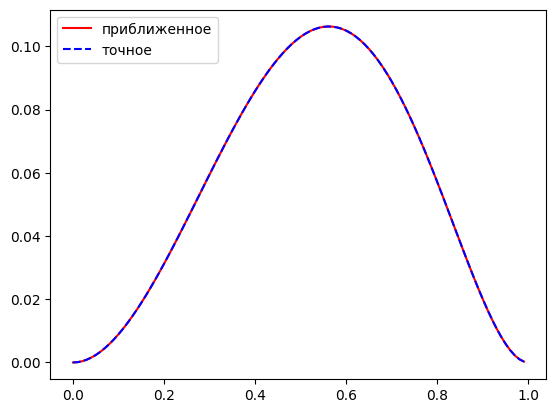

In [ ]:
import time
# решаем задачу на последовательности сеток, начиная с 5

i=5
Solution_array = [  ]
#error = []

error_abs = []
error_rel = []
cond_numbers = []
times = []

X_cor = np.linspace(X0, X1, 100)
u_ex = np.array([u_exact(i) for i in X_cor])

# засекаем время
start_time = time.time() 
    
while i <= 160:
    # решаем задачу
    ans = Global_matrix_solution(i)
    end_time = time.time()
    calc_time = end_time - start_time
    
   # print("Time in seconds:", time.time()-end_time)
    
    # сохраняем решение в массив решений
    Solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(x, ans[0], ans[1]) for x in X_cor])
    
    # вычисляем погрешности
    abs_error = np.max(np.abs(u_ - u_ex))
    rel_error = abs_error / np.max(np.abs(u_ex))

    error_abs.append(abs_error)
    error_rel.append(rel_error)
    cond_numbers.append(ans[2])
    times.append(calc_time)

    print(i)
    print(f"N_cells = {i}: E_a = {abs_error:.2e}, E_r = {rel_error:.2e}, μ(A) = {ans[2]:.2e}, t = {calc_time:.2f} с")
    
    i=i*2

print("="*120)

# отрисовка последнего решения (можно поменять на любое из массива решений)
plot_solution(Solution_array[-1])



In [ ]:
# импортируем утилиту для отрисовки красивых таблиц
# для установки в коммандной строке прописать: pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Mesh", "Error_absolute", "Order abs", "Error_relative", "Order", "Cond_Global_matrix", "Time, s"]

rate = [0]
rate_abs = [0]
for i in range(len(error_rel)-1):
    rate.append(np.log2(error_rel[i]/error_rel[i+1]))
    rate_abs.append(np.log2(error_abs[i]/error_abs[i+1]))
for i in range(len(error_rel)):
    x.add_row([5*2**(i), "{:2.2e}".format(error_abs[i]), "{:2.2e}".format(rate_abs[i]), "{:2.2e}".format(error_rel[i]), "{:2.2e}".format(rate[i]), "{:2.2e}".format(Solution_array[i][2]), f"{times[i]:.2f}"])
print(x)

+------+----------------+-----------+----------------+----------+--------------------+---------+
| Mesh | Error_absolute | Order abs | Error_relative |  Order   | Cond_Global_matrix | time, s |
+------+----------------+-----------+----------------+----------+--------------------+---------+
|  5   |    6.65e-04    |  0.00e+00 |    6.26e-03    | 0.00e+00 |      4.50e+04      |   0.02  |
|  10  |    1.67e-04    |  1.99e+00 |    1.57e-03    | 1.99e+00 |      6.73e+05      |   0.05  |
|  20  |    4.20e-05    |  2.00e+00 |    3.95e-04    | 2.00e+00 |      1.07e+07      |   0.15  |
|  40  |    1.05e-05    |  2.00e+00 |    9.88e-05    | 2.00e+00 |      1.70e+08      |   0.38  |
|  80  |    2.62e-06    |  2.00e+00 |    2.47e-05    | 2.00e+00 |      2.73e+09      |   0.91  |
| 160  |    6.56e-07    |  2.00e+00 |    6.17e-06    | 2.00e+00 |      4.36e+10      |   2.60  |
+------+----------------+-----------+----------------+----------+--------------------+---------+
